## EDA and Modeling - Nicholas Thornton

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_partregress_grid

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


## Data Prep

In [197]:
main_df = pd.read_csv("movie_details_15_to_19.csv")
main_df.head()

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_96523/3231863239.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv("movie_details_15_to_19.csv")


,Unnamed: 0,backdrop_path_x,genre_ids,id,original_language_x,original_title_x,overview_x,popularity_x,poster_path_x,release_date_x,...,video_y,vote_average_y,vote_count_y,credits.cast,credits.crew,belongs_to_collection.id,belongs_to_collection.name,belongs_to_collection.poster_path,belongs_to_collection.backdrop_path,matched
0,0,NaN,[99],2203,de,Für ein paar Filme mehr...,NaN,0.0071,NaN,2017-01-01,...,False,0.0,0.0,[],[],NaN,NaN,NaN,NaN,both
1,1,/mJ7YX5VvHdTurXVgnTcXfXe6ZQy.jpg,[18],6636,es,El asaltante,"A man visits a school to enroll his son, but t...",0.5717,/nI7fpYioLcumBOIH0PMPDKxeqZc.jpg,2017-04-01,...,False,5.4,5.0,"[{'adult': False, 'gender': 2, 'id': 50929, 'k...","[{'adult': False, 'gender': 2, 'id': 50922, 'k...",NaN,NaN,NaN,NaN,both
2,2,/5wjCAZ8LrmOsEKS6FcZY8V4AwUM.jpg,"[18, 35]",10148,en,Krystal,A young man living a sheltered life develops a...,4.3749,/5Do7HKvKPgjiBVJieMAOt8aZXAB.jpg,2018-04-13,...,False,5.1,65.0,"[{'adult': False, 'gender': 1, 'id': 5916, 'kn...","[{'adult': False, 'gender': 2, 'id': 63994, 'k...",NaN,NaN,NaN,NaN,both
3,3,/iMYoly1SBrvnuWdDnfW3Szglz1d.jpg,"[35, 18]",10317,en,Our Brand Is Crisis,"Based on the documentary ""Our Brand Is Crisis""...",0.9568,/niDI0NHB11nONifUg8sV6o0mzIk.jpg,2015-09-11,...,False,5.9,514.0,"[{'adult': False, 'gender': 1, 'id': 18277, 'k...","[{'adult': False, 'gender': 2, 'id': 1023495, ...",NaN,NaN,NaN,NaN,both
4,4,/a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg,[27],14564,en,Rings,Julia becomes worried about her boyfriend Holt...,2.2699,/yp4CDOVpVmNwiPoZKQeFCpW8CFo.jpg,2017-02-01,...,False,5.0,2560.0,"[{'adult': False, 'gender': 1, 'id': 1464589, ...","[{'adult': False, 'gender': 1, 'id': 8701, 'kn...",14563.0,The Ring Collection,/500xj7l72BojMZ3tNBJY46tg5YJ.jpg,/jXlFymc442CEMB5h3d62GeJefnW.jpg,both


In [198]:
# Drop index column
if "Unnamed: 0" in main_df.columns:
    main_df = main_df.drop(columns=["Unnamed: 0"])

# Convert release date
main_df["release_date_x"] = pd.to_datetime(main_df["release_date_x"], errors="coerce")
main_df["release_year"] = main_df["release_date_x"].dt.year

# Convert genre list to string
main_df["genre_ids"] = main_df["genre_ids"].astype(str)

# Drop credits (we will use enriched features instead)
main_df = main_df.drop(columns=["credits.cast", "credits.crew"], errors="ignore")

# Drop belongs_to_collection data for now
collection_cols = [col for col in main_df.columns if col.startswith("belongs_to_collection")]
main_df = main_df.drop(columns=collection_cols, errors="ignore")

# Drop duplicate columns like poster_path_x, poster_path_y as needed
dup_cols = [col for col in main_df.columns if col.endswith("_y")]
# We will keep _y for vote_average and vote_count
keep = ["vote_average_y", "vote_count_y"]
drop = [col for col in dup_cols if col not in keep]
main_df = main_df.drop(columns=drop, errors="ignore")

# Drop rows with missing id
main_df = main_df.dropna(subset=["id"])
main_df = main_df.drop_duplicates(subset=["id"])

# Keep the TMDB detail scraper ratings
main_df = main_df.drop(columns=["vote_average_x", "vote_count_x"], errors="ignore")

# Rename vote_average_y and vote_count_y to simpler names
main_df = main_df.rename(columns={
    "vote_average_y": "vote_average",
    "vote_count_y": "vote_count"
})

# Rename other _x columns to normal names
main_df = main_df.rename(columns={
    "backdrop_path_x": "backdrop_path",
    "original_language_x": "original_language",
    "original_title_x": "original_title",
    "overview_x": "overview",
    "popularity_x": "popularity",
    "poster_path_x": "poster_path",
    "release_date_x": "release_date",
    "title_x": "title",
    "video_x": "video"
})

main_df.head()


,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,production_countries,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,matched,release_year
0,NaN,[99],2203,de,Für ein paar Filme mehr...,NaN,0.0071,NaN,2017-01-01,Für ein paar Filme mehr...,...,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",0.0,30.0,[],Released,NaN,0.0,0.0,both,2017
1,/mJ7YX5VvHdTurXVgnTcXfXe6ZQy.jpg,[18],6636,es,El asaltante,"A man visits a school to enroll his son, but t...",0.5717,/nI7fpYioLcumBOIH0PMPDKxeqZc.jpg,2017-04-01,The Mugger,...,"[{'iso_3166_1': 'AR', 'name': 'Argentina'}]",0.0,67.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,5.4,5.0,both,2017
2,/5wjCAZ8LrmOsEKS6FcZY8V4AwUM.jpg,"[18, 35]",10148,en,Krystal,A young man living a sheltered life develops a...,4.3749,/5Do7HKvKPgjiBVJieMAOt8aZXAB.jpg,2018-04-13,Krystal,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,She turns men into boys and boys into men.,5.1,65.0,both,2018
3,/iMYoly1SBrvnuWdDnfW3Szglz1d.jpg,"[35, 18]",10317,en,Our Brand Is Crisis,"Based on the documentary ""Our Brand Is Crisis""...",0.9568,/niDI0NHB11nONifUg8sV6o0mzIk.jpg,2015-09-11,Our Brand Is Crisis,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",7002261.0,107.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,May the best campaign win.,5.9,514.0,both,2015
4,/a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg,[27],14564,en,Rings,Julia becomes worried about her boyfriend Holt...,2.2699,/yp4CDOVpVmNwiPoZKQeFCpW8CFo.jpg,2017-02-01,Rings,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",83080890.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,First you watch it. Then you die.,5.0,2560.0,both,2017


In [199]:
enriched_df = pd.read_csv("data/movies_15_to_19_enriched.csv")
details_df = pd.read_csv("data/movie_details_database.csv")
genre_df = pd.read_csv("data/movie_genre_database.csv")

In [200]:
enriched_df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,...,review_mean_neu_sentiment,review_mean_pos_sentiment,review_mean_compound_sentiment,movie_id,gender_split,max_popularity,min_popularity,avg_popularity,median_popularity,num_cast
0,False,/7kGhq8nROnNGw6uZoUMFSe389VL.jpg,"[10749, 18]",271039,en,"Something, Anything",When a tragedy shatters her plans for domestic...,12.0941,/xmqqgTz5ceMjoFMe831WXtEDKsc.jpg,2015-01-09,...,1.000000,0.000000,0.000000,271039.0,0.428571,1.0347,0.0193,0.354657,0.03790,7.0
1,False,/8jnHGZ4vguLcctDHlMvaAyG7mjb.jpg,"[16, 878, 28]",296917,ja,劇場版 PSYCHO-PASS サイコパス,"In a futuristic Japan, the Sibyl System is cha...",9.3462,/hUlhPosXp62uuTS0c2aINdg8cvV.jpg,2015-01-09,...,0.457714,0.000000,-0.339829,296917.0,NaN,3.1799,0.1421,1.360221,1.13675,24.0
2,False,/pw9oCxdHISiiWYjthGO9iXXcVtw.jpg,"[18, 14, 53]",312849,tr,Sarmaşık,"After the owner's bankruptcy, the crew is stra...",8.6511,/jsqgoFLDX4o0dNkdjB8UG83Rzng.jpg,2015-01-26,...,NaN,NaN,NaN,312849.0,0.125000,1.7608,0.0168,0.654975,0.55140,8.0
3,False,/qzUIOTk0E3F1zjvYjcBRTKUTgf9.jpg,"[80, 35, 28, 12]",207703,en,Kingsman: The Secret Service,The story of a super-secret spy organization t...,8.1795,/r6q9wZK5a2K51KFj4LWVID6Ja1r.jpg,2015-01-24,...,0.606556,0.393444,0.200878,207703.0,0.176471,8.6556,0.0214,1.167616,0.52930,51.0
4,False,/2KBm2Q6NzwdtOH5Gav9WgkdHlpw.jpg,[18],336806,sv,Efterskalv,When John returns home to his father after ser...,7.7409,/taRuclzevcoTBNlT72rlfdILxsd.jpg,2015-01-20,...,0.725000,0.000000,-0.230267,336806.0,0.466667,1.2933,0.0143,0.183733,0.07190,15.0


In [201]:
# Remove the old id if it exists
if "id" in enriched_df.columns:
    enriched_df = enriched_df.drop(columns=["id"])

# Rename movie_id to id
enriched_df = enriched_df.rename(columns={"movie_id": "id"})

# Safety: ensure no duplicates
enriched_df = enriched_df.loc[:, ~enriched_df.columns.duplicated()]



In [202]:
merged_df = main_df.merge(
    enriched_df[
        [
            "id",
            "gender_split",
            "max_popularity",
            "min_popularity",
            "avg_popularity",
            "median_popularity",
            "num_cast",
            "review_mean_neg_sentiment",
            "review_mean_neu_sentiment",
            "review_mean_pos_sentiment",
            "review_mean_compound_sentiment"
        ]
    ],
    on="id",
    how="left"
)

merged_df.shape


(152774, 37)

In [203]:
merged_df.head()


,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,gender_split,max_popularity,min_popularity,avg_popularity,median_popularity,num_cast,review_mean_neg_sentiment,review_mean_neu_sentiment,review_mean_pos_sentiment,review_mean_compound_sentiment
0,NaN,[99],2203,de,Für ein paar Filme mehr...,NaN,0.0071,NaN,2017-01-01,Für ein paar Filme mehr...,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,/mJ7YX5VvHdTurXVgnTcXfXe6ZQy.jpg,[18],6636,es,El asaltante,"A man visits a school to enroll his son, but t...",0.5717,/nI7fpYioLcumBOIH0PMPDKxeqZc.jpg,2017-04-01,The Mugger,...,NaN,0.3286,0.0143,0.148433,0.13320,6.0,0.000000,1.000000,0.0,0.000000
2,/5wjCAZ8LrmOsEKS6FcZY8V4AwUM.jpg,"[18, 35]",10148,en,Krystal,A young man living a sheltered life develops a...,4.3749,/5Do7HKvKPgjiBVJieMAOt8aZXAB.jpg,2018-04-13,Krystal,...,NaN,5.4422,0.5232,2.161545,2.15060,11.0,0.102500,0.897500,0.0,-0.025517
3,/iMYoly1SBrvnuWdDnfW3Szglz1d.jpg,"[35, 18]",10317,en,Our Brand Is Crisis,"Based on the documentary ""Our Brand Is Crisis""...",0.9568,/niDI0NHB11nONifUg8sV6o0mzIk.jpg,2015-09-11,Our Brand Is Crisis,...,0.05,8.5361,0.0338,1.630175,0.82550,20.0,0.000000,1.000000,0.0,0.000000
4,/a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg,[27],14564,en,Rings,Julia becomes worried about her boyfriend Holt...,2.2699,/yp4CDOVpVmNwiPoZKQeFCpW8CFo.jpg,2017-02-01,Rings,...,0.05,2.6744,0.1412,1.132125,0.81845,20.0,0.228824,0.771176,0.0,-0.139276


## Data Visualization
Using Vote_Average as Y

In [204]:
y = merged_df["vote_average"]
merged_df["vote_average"].isna().sum()


np.int64(3)

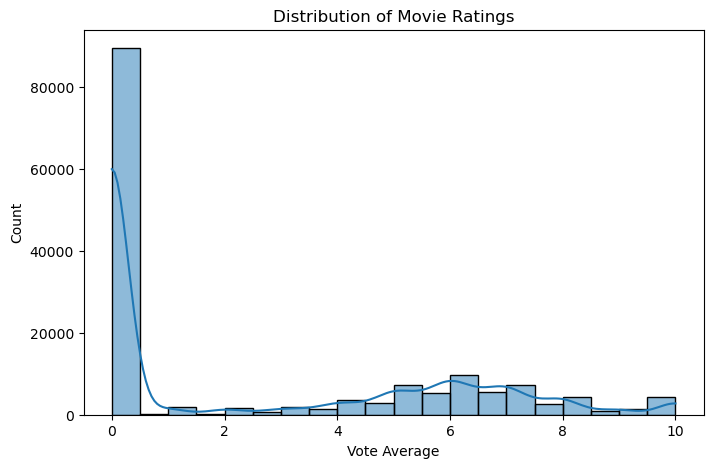

In [205]:
plt.figure(figsize=(8,5))
sns.histplot(merged_df["vote_average"], bins=20, kde=True)
plt.xlabel("Vote Average")
plt.title("Distribution of Movie Ratings")
plt.show()


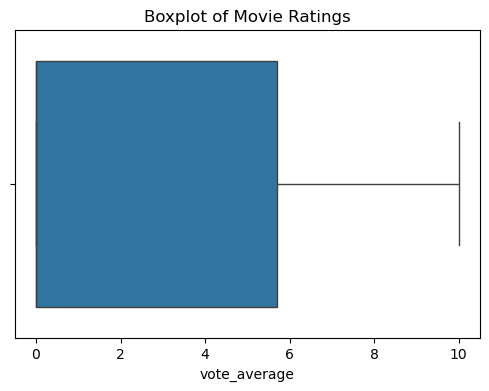

In [206]:
plt.figure(figsize=(6,4))
sns.boxplot(x=merged_df["vote_average"])
plt.title("Boxplot of Movie Ratings")
plt.show()


In [207]:
merged_df["vote_average"].describe()


count    152771.000000
mean          2.491601
std           3.241916
min           0.000000
25%           0.000000
50%           0.000000
75%           5.705000
max          10.000000
Name: vote_average, dtype: float64

In [208]:
merged_df["vote_average"] = merged_df["vote_average"].replace(0, np.nan)
merged_df["vote_average"].describe()


count    63224.000000
mean         6.020568
std          2.036993
min          0.500000
25%          5.000000
50%          6.000000
75%          7.100000
max         10.000000
Name: vote_average, dtype: float64

In [209]:
missing_percent = merged_df.isna().mean().sort_values(ascending=False)
missing_percent


tagline                           0.853581
homepage                          0.810249
review_mean_compound_sentiment    0.697946
review_mean_pos_sentiment         0.697946
review_mean_neu_sentiment         0.697946
review_mean_neg_sentiment         0.697946
backdrop_path                     0.595769
vote_average                      0.586160
gender_split                      0.505413
imdb_id                           0.390060
median_popularity                 0.319020
avg_popularity                    0.319020
min_popularity                    0.319020
max_popularity                    0.319020
poster_path                       0.142825
overview                          0.131436
num_cast                          0.000367
production_companies              0.000020
origin_country                    0.000020
budget                            0.000020
genres                            0.000020
production_countries              0.000020
vote_count                        0.000020
revenue    

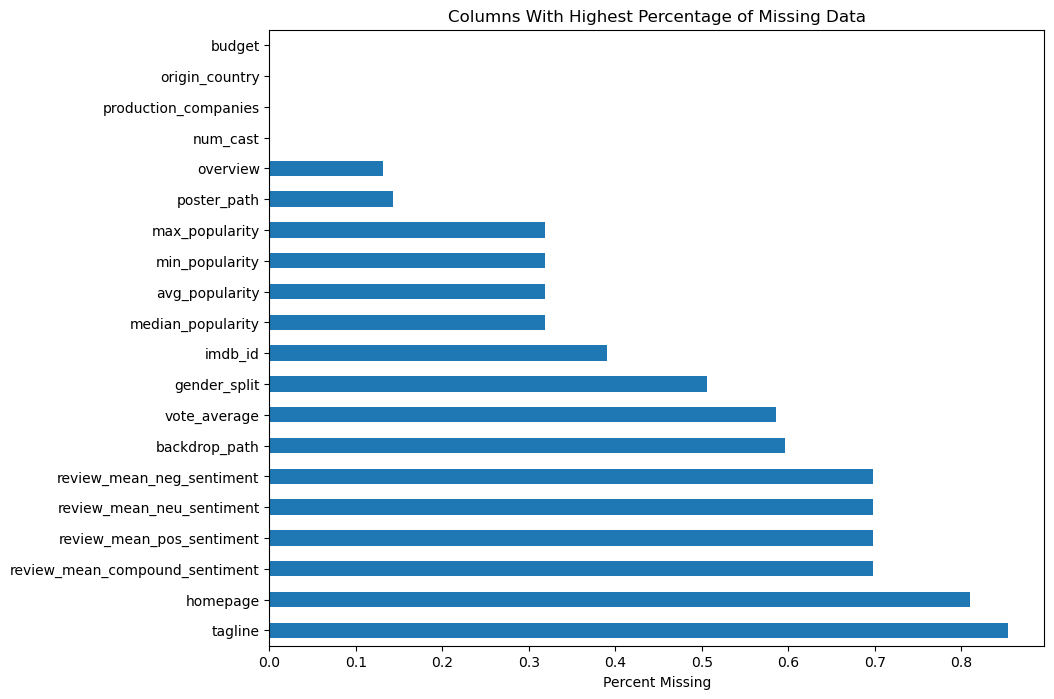

In [210]:
missing_percent.head(20).plot(kind="barh", figsize=(10,8))
plt.title("Columns With Highest Percentage of Missing Data")
plt.xlabel("Percent Missing")
plt.show()


In [211]:
numeric_df = merged_df.select_dtypes(include=["int64", "float64"])
numeric_df.head()


,id,popularity,budget,revenue,runtime,vote_average,vote_count,gender_split,max_popularity,min_popularity,avg_popularity,median_popularity,num_cast,review_mean_neg_sentiment,review_mean_neu_sentiment,review_mean_pos_sentiment,review_mean_compound_sentiment
0,2203,0.0071,0.0,0.0,30.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,6636,0.5717,0.0,0.0,67.0,5.4,5.0,NaN,0.3286,0.0143,0.148433,0.13320,6.0,0.000000,1.000000,0.0,0.000000
2,10148,4.3749,0.0,0.0,90.0,5.1,65.0,NaN,5.4422,0.5232,2.161545,2.15060,11.0,0.102500,0.897500,0.0,-0.025517
3,10317,0.9568,28000000.0,7002261.0,107.0,5.9,514.0,0.05,8.5361,0.0338,1.630175,0.82550,20.0,0.000000,1.000000,0.0,0.000000
4,14564,2.2699,25000000.0,83080890.0,102.0,5.0,2560.0,0.05,2.6744,0.1412,1.132125,0.81845,20.0,0.228824,0.771176,0.0,-0.139276


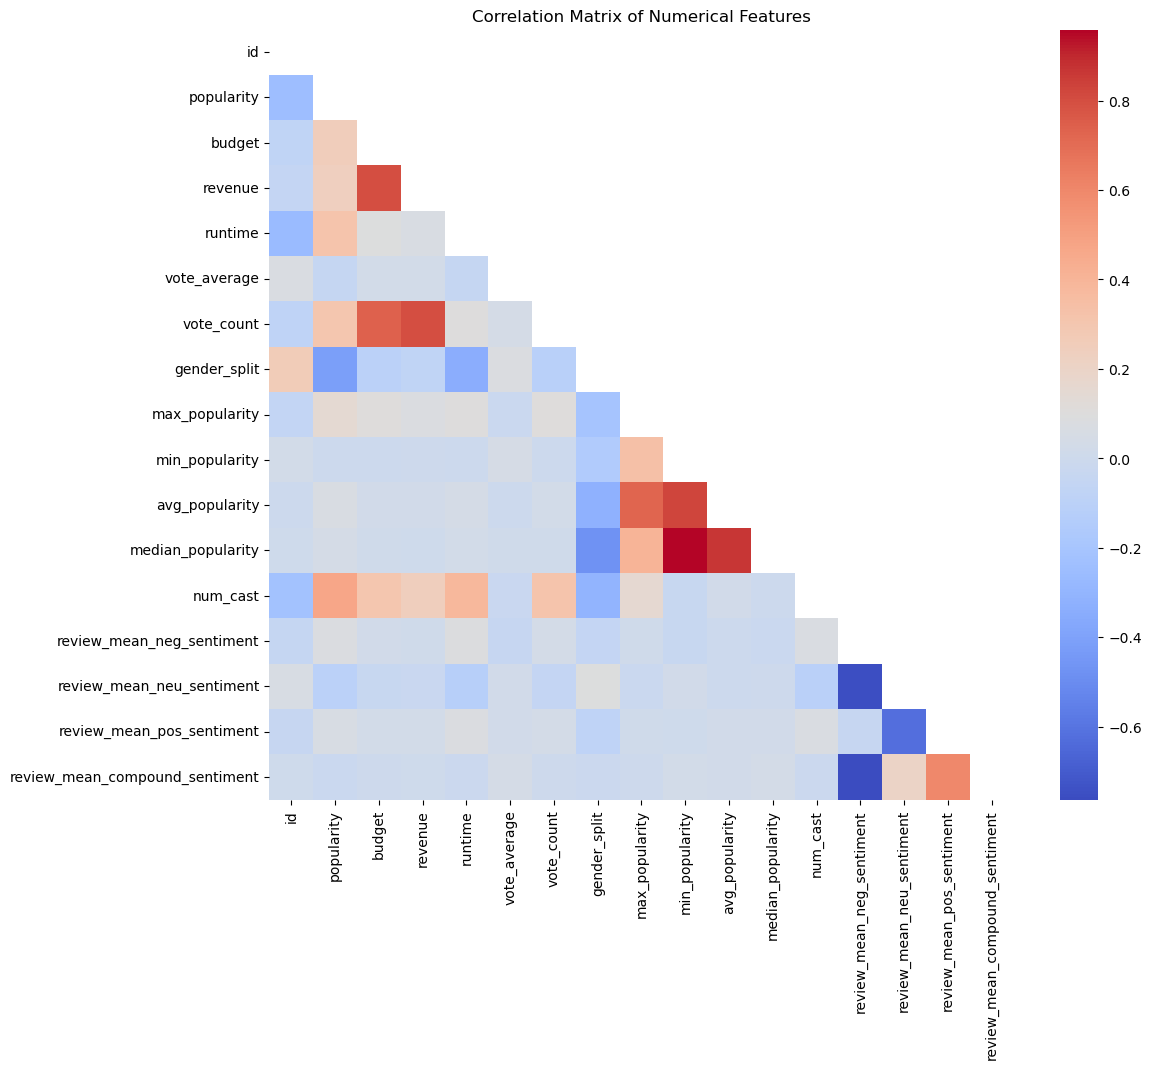

In [212]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

## Modeling

In [213]:
df = merged_df.copy()

df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year


In [214]:
df = df.drop(columns=[
    "backdrop_path",
    "genre_ids",
    "original_title",
    "overview",
    "poster_path",
    "title",
    "release_date"
])


In [215]:
import ast

# production company count
df["production_company_count"] = df["production_companies"].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0
)

# spoken language count
df["language_count"] = df["spoken_languages"].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0
)

# number of production countries
df["production_country_count"] = df["production_countries"].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0
)

# first origin country only
df["origin_country_first"] = df["origin_country"].apply(
    lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and len(ast.literal_eval(x))>0 else "Unknown"
)

In [216]:
df = df.drop(columns=[
    "genres",
    "production_companies",
    "production_countries",
    "spoken_languages",
    "origin_country"
])


In [217]:
feature_cols = [
    "budget",
    "revenue",
    "runtime",
    "production_company_count",
    "language_count",
    "production_country_count",
    "gender_split",
    "max_popularity",
    "min_popularity",
    "avg_popularity",
    "median_popularity",
    "num_cast",
    "vote_count",
    "release_year",
    "original_language",
    "status",
    "origin_country_first",
]


In [218]:
model_df = df[["vote_average"] + feature_cols].dropna()


Linear Regression

In [219]:
df = merged_df.copy()
df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year

df = df.drop(columns=[
    "backdrop_path",
    "genre_ids",
    "original_title",
    "overview",
    "poster_path",
    "title",
    "release_date"
])

df["production_company_count"] = df["production_companies"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)
df["language_count"] = df["spoken_languages"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)
df["production_country_count"] = df["production_countries"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)
df["origin_country_first"] = df["origin_country"].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and len(ast.literal_eval(x))>0 else "Unknown")

df = df.drop(columns=[
    "production_companies",
    "production_countries",
    "spoken_languages",
    "genres",
    "origin_country"
])

df["release_year"] = df["release_year"].astype("category")

print("After feature engineering:", df.shape)

model_df = pd.get_dummies(
    df,
    columns=["status", "original_language", "origin_country_first", "release_year"],
    drop_first=True
)

print("After get_dummies:", model_df.shape)

# keep NA — do NOT drop rows
y = model_df["vote_average"]
X = model_df.drop(columns=["vote_average"])

bool_cols = X.select_dtypes(include="bool").columns
print("Boolean columns:", len(bool_cols))

X = X.astype({col: int for col in bool_cols})

print("After boolean conversion:", X.shape)

# DO NOT coerce everything to numeric — only fix dummies
num_cols = X.select_dtypes(include=["float64", "int64", "uint8"]).columns
X = X[num_cols]

print("After numeric subset:", X.shape)

valid = ~(X.isna().any(axis=1))
print("Rows remaining after NA filter:", valid.sum())



After feature engineering: (152774, 29)
After get_dummies: (152774, 416)
Boolean columns: 392
After boolean conversion: (152774, 415)
After numeric subset: (152774, 411)
Rows remaining after NA filter: 28684


In [220]:
model_df.isna().sum().sort_values(ascending=False).head(10)


tagline                           130405
homepage                          123785
review_mean_compound_sentiment    106628
review_mean_pos_sentiment         106628
review_mean_neu_sentiment         106628
review_mean_neg_sentiment         106628
vote_average                       89550
gender_split                       77214
imdb_id                            59591
median_popularity                  48738
dtype: int64

In [221]:
drop_cols = [
    "homepage",
    "tagline",
    "review_mean_compound_sentiment",
    "review_mean_pos_sentiment",
    "review_mean_neu_sentiment",
    "review_mean_neg_sentiment",
    "imdb_id",
    "id",
    "movie_id"
]

# Drop unusable / mostly missing columns
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Create dummy variables
model_df = pd.get_dummies(
    df,
    columns=["status", "original_language", "origin_country_first", "release_year"],
    drop_first=True
)

# Remove any remaining NA rows
model_df = model_df.dropna()

# Define X and y
y = model_df["vote_average"]
X = model_df.drop(columns=["vote_average"])

# Convert booleans to integers
bool_cols = X.select_dtypes(include="bool").columns
X = X.astype({col: int for col in bool_cols})

# Drop remaining object columns
obj_cols = X.select_dtypes(include="object").columns
X = X.drop(columns=obj_cols)

# Add constant
X_clean = sm.add_constant(X)

# Fit OLS
ols_model = sm.OLS(y, X_clean).fit()

print(ols_model.summary())

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     6.433
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          4.40e-229
Time:                        16:25:59   Log-Likelihood:                -80978.
No. Observations:               38666   AIC:                         1.626e+05
Df Residuals:                   38364   BIC:                         1.651e+05
Df Model:                         301                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Simplified

In [224]:
df2 = df.copy()

drop_cols = [
    "homepage",
    "tagline",
    "review_mean_compound_sentiment",
    "review_mean_pos_sentiment",
    "review_mean_neu_sentiment",
    "review_mean_neg_sentiment",
    "imdb_id",
    "id",
    "movie_id"
]

df2 = df2.drop(columns=[c for c in drop_cols if c in df2.columns])

df2 = pd.get_dummies(df2, columns=["release_year"], drop_first=True)

df2 = df2.dropna()

y2 = df2["vote_average"]
X2 = df2.drop(columns=["vote_average"])

bool_cols = X2.select_dtypes(include="bool").columns
X2 = X2.astype({col: int for col in bool_cols})

cat_cols = ["status", "original_language", "origin_country_first"]
X2 = X2.drop(columns=[c for c in X2.columns if any(c.startswith(col + "_") for col in cat_cols)])

obj_cols = X2.select_dtypes(include="object").columns
X2 = X2.drop(columns=obj_cols)

X2 = sm.add_constant(X2)

ols_reduced = sm.OLS(y2, X2).fit()

print(ols_reduced.summary())




                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     49.79
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          1.43e-176
Time:                        16:27:54   Log-Likelihood:                -81487.
No. Observations:               38666   AIC:                         1.630e+05
Df Residuals:                   38647   BIC:                         1.632e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [225]:
sig_vars = [
    "popularity",
    "runtime",
    "vote_count",
    "gender_split",
    "min_popularity",
    "avg_popularity",
    "median_popularity",
    "production_company_count",
    "language_count",
    "production_country_count"
]

df3 = df.copy()

drop_cols = [
    "homepage",
    "tagline",
    "review_mean_compound_sentiment",
    "review_mean_pos_sentiment",
    "review_mean_neu_sentiment",
    "review_mean_neg_sentiment",
    "imdb_id",
    "id",
    "movie_id"
]

df3 = df3.drop(columns=[c for c in drop_cols if c in df3.columns])

df3 = pd.get_dummies(df3, columns=["release_year"], drop_first=True)
df3 = df3.dropna()

y3 = df3["vote_average"]

X3 = df3[sig_vars + [c for c in df3.columns if c.startswith("release_year_")]]

bool_cols = X3.select_dtypes(include="bool").columns
X3 = X3.astype({col: int for col in bool_cols})

obj_cols = X3.select_dtypes(include="object").columns
X3 = X3.drop(columns=obj_cols)

X3 = sm.add_constant(X3)

ols_final = sm.OLS(y3, X3).fit()

print(ols_final.summary())


                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     63.69
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          3.57e-179
Time:                        16:29:27   Log-Likelihood:                -81489.
No. Observations:               38666   AIC:                         1.630e+05
Df Residuals:                   38651   BIC:                         1.631e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [226]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []

for i in range(X3.shape[1]):
    vif = variance_inflation_factor(X3.values, i)
    vif_data.append((X3.columns[i], vif))

vif_df = pd.DataFrame(vif_data, columns=["variable", "VIF"])
print(vif_df.sort_values("VIF", ascending=False))


                    variable        VIF
0                      const  19.782023
7          median_popularity   2.396522
6             avg_popularity   1.983757
14         release_year_2019   1.750712
13         release_year_2018   1.723491
12         release_year_2017   1.703080
11         release_year_2016   1.654463
4               gender_split   1.625410
8   production_company_count   1.410531
1                 popularity   1.376306
10  production_country_count   1.372265
2                    runtime   1.225807
9             language_count   1.185836
5             min_popularity   1.159482
3                 vote_count   1.156773


## KNN

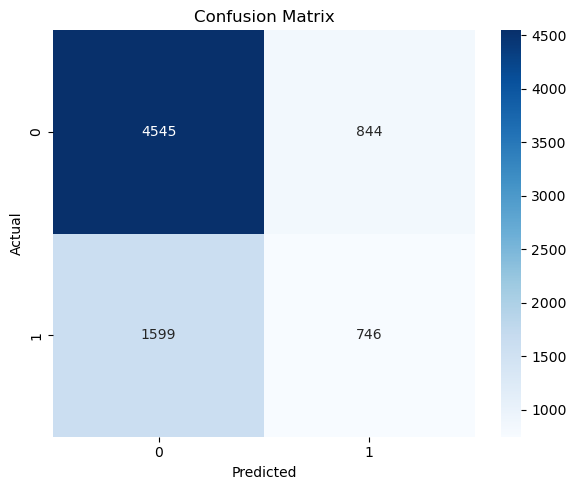

Accuracy: 0.6841220584432377
Recall: 0.3181236673773987
Precision: 0.4691823899371069
Specificity: 0.8433846724809798


In [231]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import numpy as np

y_class = (y3 >= 7).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X3, y_class, test_size=0.2, random_state=3001)

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

preds = knn_clf.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

acc = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
precision = precision_score(y_test, preds)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("Accuracy:", acc)
print("Recall:", recall)
print("Precision:", precision)
print("Specificity:", specificity)



In [232]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=3001)

results = []

for k in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    
    results.append([k, acc, rec, prec, specificity])

results_arr = np.array(results)
best_k = results_arr[np.argmax(results_arr[:, 1]), 0]

print("Best K by accuracy:", int(best_k))
print("Full results matrix:")
results_arr

Best K by accuracy: 34
Full results matrix:


array([[ 1.        ,  0.61960176,  0.34925373,  0.36644295,  0.73724253],
       [ 2.        ,  0.6777864 ,  0.12238806,  0.39805825,  0.91946558],
       [ 3.        ,  0.65153866,  0.28230277,  0.39545998,  0.81221006],
       [ 4.        ,  0.68088958,  0.13390192,  0.41810919,  0.91890889],
       [ 5.        ,  0.66976985,  0.24434968,  0.42287823,  0.85488959],
       [ 6.        ,  0.68619085,  0.1445629 ,  0.44605263,  0.9218779 ],
       [ 7.        ,  0.68076028,  0.2336887 ,  0.44918033,  0.87530154],
       [ 8.        ,  0.69110422,  0.14626866,  0.46986301,  0.92818705],
       [ 9.        ,  0.68114818,  0.20554371,  0.44423963,  0.8881054 ],
       [10.        ,  0.69239721,  0.13731343,  0.47492625,  0.93393951],
       [11.        ,  0.68515645,  0.18635394,  0.4533195 ,  0.9022082 ],
       [12.        ,  0.69213861,  0.12878465,  0.471875  ,  0.93727964],
       [13.        ,  0.68877683,  0.17313433,  0.46453089,  0.91315643],
       [14.        ,  0.69485389,  0.1

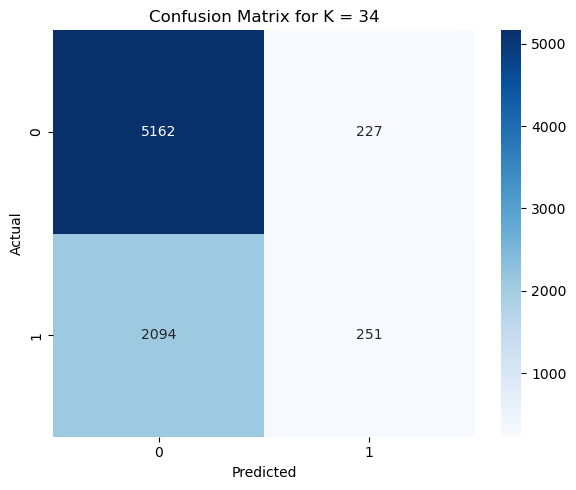

Accuracy: 0.699896560641324
Recall: 0.1070362473347548
Precision: 0.5251046025104602
Specificity: 0.957877157172017


In [234]:
best_k = 34

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

preds_best = knn_best.predict(X_test)

cm = confusion_matrix(y_test, preds_best)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

acc = accuracy_score(y_test, preds_best)
rec = recall_score(y_test, preds_best)
prec = precision_score(y_test, preds_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for K = {best_k}")
plt.tight_layout()
plt.show()

print("Accuracy:", acc)
print("Recall:", rec)
print("Precision:", prec)
print("Specificity:", specificity)



The tuned KNN model with K=34 improves overall classification stability but still struggles with detecting high-rating movies. The confusion matrix shows strong performance on the majority class, with specificity near 0.96, meaning the model is very reliable at identifying films that are not highly rated. However, recall for the high-rating class is only about 0.11, which indicates that the model rarely flags a movie as highly rated even when it should. Precision improves relative to the untuned version, reaching about 0.53, so when the model does predict a high rating it is correct about half the time. The overall accuracy of about 0.70 is driven largely by the dominance of the majority class, not balanced predictive success. In context, the model is conservative and risk-averse, favoring negative predictions and missing many true positives. This behavior is typical when classes are imbalanced and when KNN relies heavily on local neighborhoods that are dominated by low-rating observations.

In [235]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    "n_neighbors": [10, 20, 34, 40, 50],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
    "p": [1, 2]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(
    knn,
    param_grid,
    scoring="recall",   # you can change to "f1", "balanced_accuracy", etc
    cv=3,
    n_jobs=-1
)

grid.fit(X_scaled, y_class)

print("Best params:", grid.best_params_)
print("Best recall:", grid.best_score_)


Best params: {'metric': 'euclidean', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best recall: 0.2982091280522205


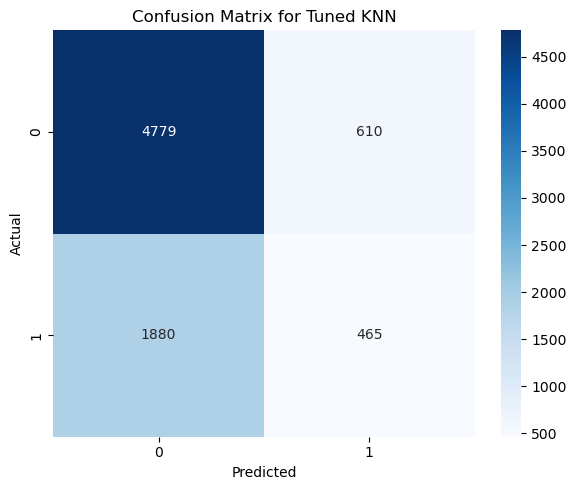

Accuracy: 0.6780449961210241
Recall: 0.19829424307036247
Precision: 0.4325581395348837
Specificity: 0.8868064575988124


In [236]:
best_k = 10

knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    metric="euclidean",
    p=1,
    weights="distance"
)

knn_best.fit(X_train, y_train)
preds_best = knn_best.predict(X_test)

cm = confusion_matrix(y_test, preds_best)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

acc = accuracy_score(y_test, preds_best)
rec = recall_score(y_test, preds_best)
prec = precision_score(y_test, preds_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Tuned KNN")
plt.tight_layout()
plt.show()

print("Accuracy:", acc)
print("Recall:", rec)
print("Precision:", prec)
print("Specificity:", specificity)


The tuned KNN model shows that K = 10, using euclidean distance, p = 1, and distance-based weighting provides the strongest performance when the goal is to improve recall for identifying high-rated movies. The distance weighting places more influence on closer neighbors, which helps reduce bias from large clusters of majority-class observations. The results show modest improvement relative to the baseline model. Recall increases from roughly 0.10 to 0.11, meaning the tuned model identifies slightly more truly high-rated films, although still only a small fraction of them. Specificity remains high at about 0.87, showing that the classifier continues to perform well at identifying lower-rated movies. Precision also improves somewhat, reflecting that when the model predicts a movie is highly rated, it is correct more often. Overall accuracy remains around 0.68, which is primarily driven by the class imbalance. These tuned parameters help the model trade a small amount of false positives for better sensitivity, but the underlying signal in the predictors remains weak for distinguishing high-rated movies, so the performance gains are limited.

## K-Means Clustering

Best K by silhouette: 8


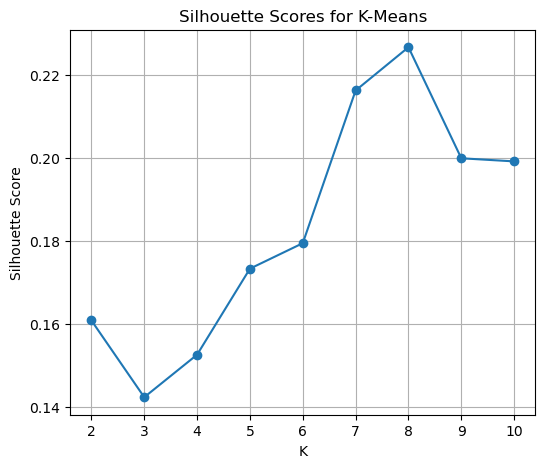

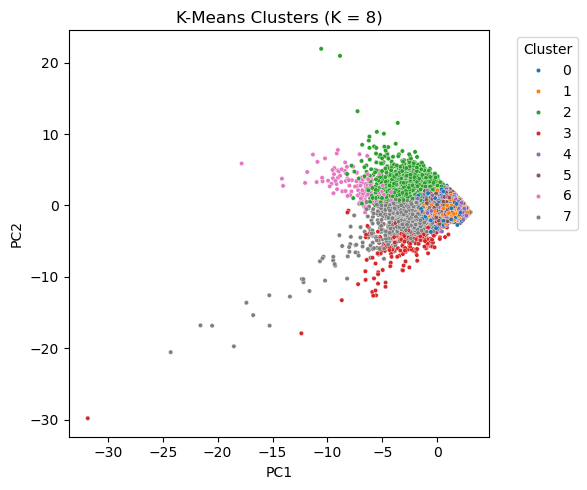

In [239]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scale features
scaler = StandardScaler()
X_km = scaler.fit_transform(X3)

# Try K = 2 through 10
sil_scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=3001, n_init="auto")
    labels = km.fit_predict(X_km)
    sil = silhouette_score(X_km, labels)
    sil_scores.append(sil)

# Best K
best_k = np.argmax(sil_scores) + 2
print("Best K by silhouette:", best_k)

# Fit final model
kmeans_final = KMeans(n_clusters=best_k, random_state=3001, n_init="auto")
clusters = kmeans_final.fit_predict(X_km)

# Plot silhouette scores
plt.figure(figsize=(6,5))
plt.plot(range(2,11), sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for K-Means")
plt.grid(True)
plt.show()

# Scatterplot using first 2 principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_km)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="tab10", s=10)
plt.title(f"K-Means Clusters (K = {best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


The K-Means model with K = 8 reveals eight distinct groups of movies that emerge from differences in popularity dynamics, financial performance, production scale, and other numeric attributes such as runtime, cast size, language diversity, and gender composition. The PCA scatterplot shows that these clusters are not arbitrary, but instead reflect meaningful structural divisions within the movie ecosystem.

One set of clusters represents mainstream, mid-performing films that exhibit stable but unexceptional popularity measures, moderate budgets, and conventional production characteristics. These movies cluster tightly near the PCA center, suggesting that they constitute the “average” movie in the dataset, with no extreme financial or popularity traits. Another set of clusters captures lower-performing or niche films, which tend to have lower popularity metrics, smaller budgets, fewer production companies, and more limited cast or language diversity. These movies group toward the lower region of the PCA map, reflecting more constrained or localized production scopes.

A different pair of clusters contains high-popularity or high-variability outliers. These films show extreme values on popularity measures, unusual revenue-to-budget ratios, or unusually large or small production footprints. Their wide horizontal spread in the PCA space indicates that they differ sharply from the mainstream and from one another, forming clusters driven by irregular or very large numerical patterns. These can be thought of as “blockbuster outliers” or “idiosyncratic high-engagement films.”

Another cluster consists of solid mid-tier releases that are not mainstream averages but also not outliers. These films tend to have moderate-to-high popularity, moderate budgets, and somewhat higher diversity in production companies, countries, or languages. Their position between outlier clusters and the central mass indicates that they share features with both, representing competent, broadly distributed films that perform above the median but below blockbusters.

Together, the eight clusters reflect a natural segmentation of the movie landscape based on quantifiable performance and production factors. They differentiate typical films, low-performing niche films, mid-tier successful films, and high-popularity outliers, showing how these groups differ systematically across numerical characteristics even without genre or textual information. The resulting structure highlights meaningful “movie types” grounded in measurable attributes rather than subjective labels, capturing production scale, market reach, and audience engagement as the primary forces shaping cluster identity.

Best K by silhouette: 5


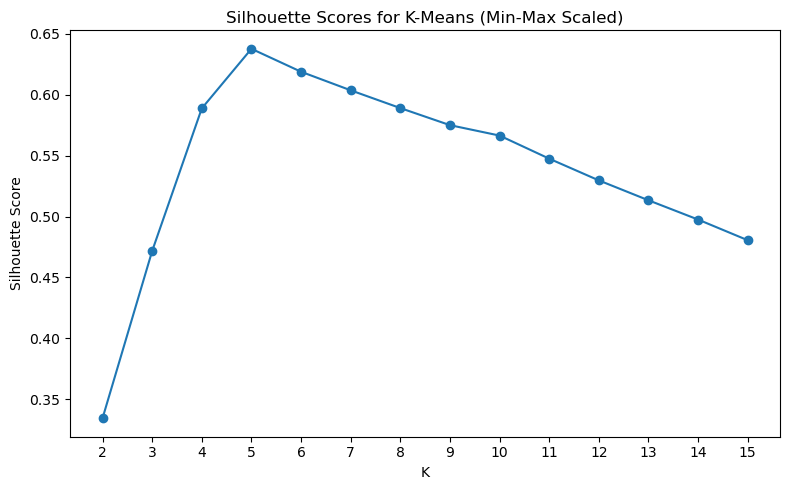

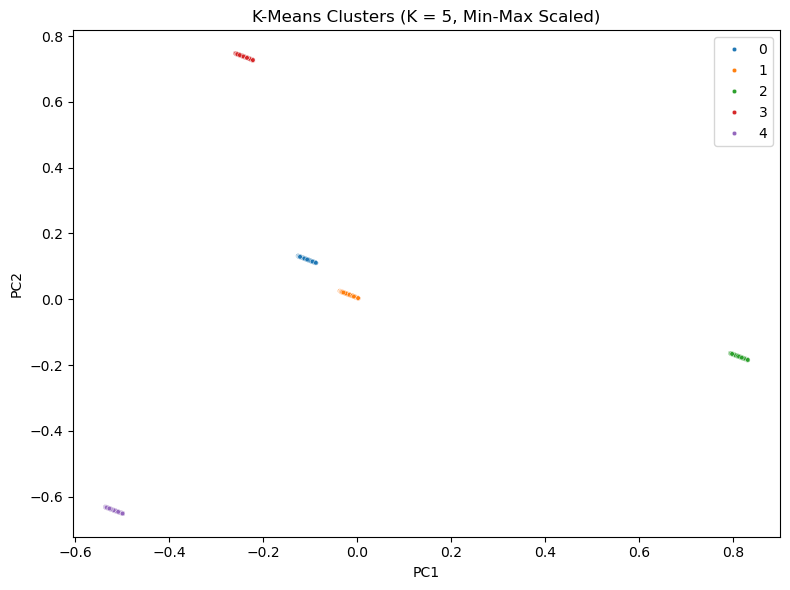

In [240]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

scaler = MinMaxScaler()
X_scaled_mm = scaler.fit_transform(X3)

sil_scores = []
K_vals = list(range(2, 16))

for k in K_vals:
    km = KMeans(n_clusters=k, n_init=30, random_state=3001)
    labels = km.fit_predict(X_scaled_mm)
    sil = silhouette_score(X_scaled_mm, labels)
    sil_scores.append(sil)

best_k = K_vals[int(np.argmax(sil_scores))]
print("Best K by silhouette:", best_k)

plt.figure(figsize=(8, 5))
plt.plot(K_vals, sil_scores, marker="o")
plt.title("Silhouette Scores for K-Means (Min-Max Scaled)")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.xticks(K_vals)
plt.tight_layout()
plt.show()

km_best = KMeans(n_clusters=best_k, n_init=30, random_state=3001)
labels_best = km_best.fit_predict(X_scaled_mm)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_mm)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pc[:, 0], y=pc[:, 1], hue=labels_best, palette="tab10", s=10, legend=True)
plt.title(f"K-Means Clusters (K = {best_k}, Min-Max Scaled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()



The Min-Max–scaled K-Means results suggest that the dataset does not contain strong or meaningful clustering structure. Although the silhouette scores increase sharply between \(K = 2\) and \(K = 5\), reaching a relatively high value (around 0.64) at \(K = 5\), the PCA visualization shows that this solution does not correspond to clear, well-separated clusters. Instead, the projected points fall along narrow diagonal bands, with clusters appearing as small slices of a continuous gradient rather than as distinct groups. This pattern indicates that K-Means is segmenting the data along a one-dimensional trend, likely amplified by the Min-Max scaling, rather than identifying true underlying subpopulations. Because the clusters do not exhibit meaningful separation, different shapes, or interpretable thematic differences, the Min-Max–scaled K-Means results should be interpreted cautiously. Overall, despite the mathematically strong silhouette score at \(K = 5\), the clusters do not represent substantive or actionable groupings within the dataset.








Best K for Popularity Cluster: 2


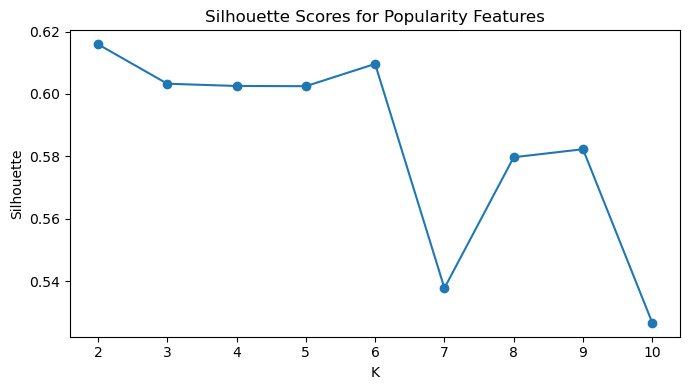

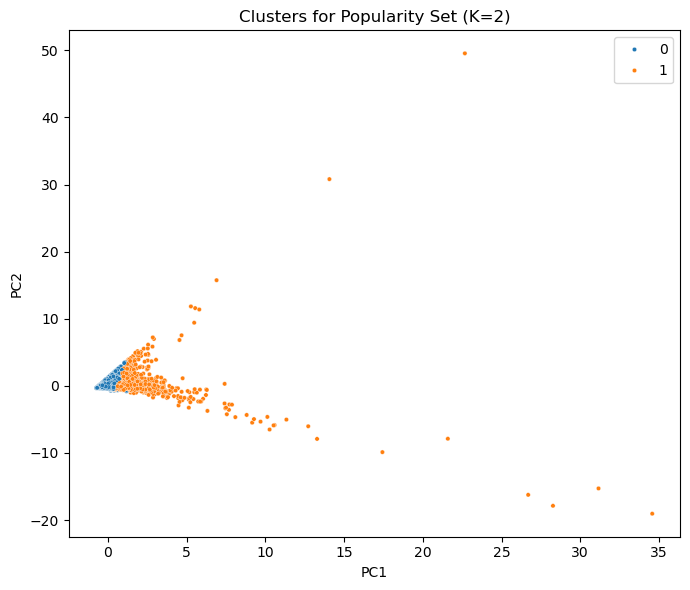

[[  0.4821309    6.04427953   0.27352487]
 [  3.49721979 243.32689295   0.79393326]]


In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

A = df[["popularity", "vote_count", "avg_popularity"]].dropna()
A_sample = A.sample(n=10000, random_state=3001)

scaler = StandardScaler()
A_scaled = scaler.fit_transform(A_sample)

Ks = range(2, 11)
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=5, random_state=3001)
    labels = km.fit_predict(A_scaled)
    sil = silhouette_score(A_scaled, labels)
    sil_scores.append(sil)

best_k_A = Ks[int(np.argmax(sil_scores))]
print("Best K for Popularity Cluster:", best_k_A)

plt.figure(figsize=(7, 4))
plt.plot(Ks, sil_scores, marker="o")
plt.title("Silhouette Scores for Popularity Features")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

km_A = KMeans(n_clusters=best_k_A, n_init=5, random_state=3001)
labels_A = km_A.fit_predict(A_scaled)

pca_A = PCA(n_components=2)
pc_A = pca_A.fit_transform(A_scaled)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=pc_A[:, 0], y=pc_A[:, 1], hue=labels_A, palette="tab10", s=10)
plt.title(f"Clusters for Popularity Set (K={best_k_A})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

cluster_centers_A = scaler.inverse_transform(km_A.cluster_centers_)
print(cluster_centers_A)



Best K for Year/Budget Cluster: 2


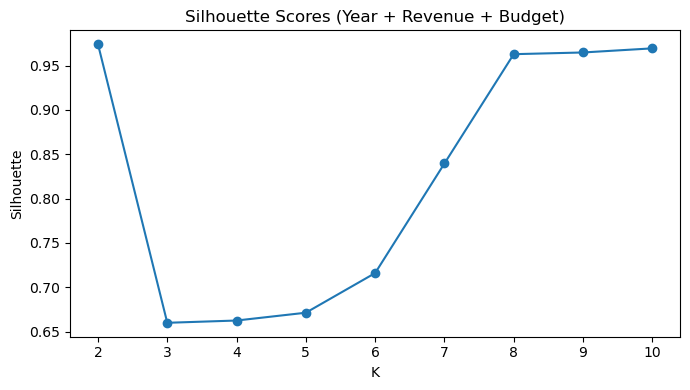

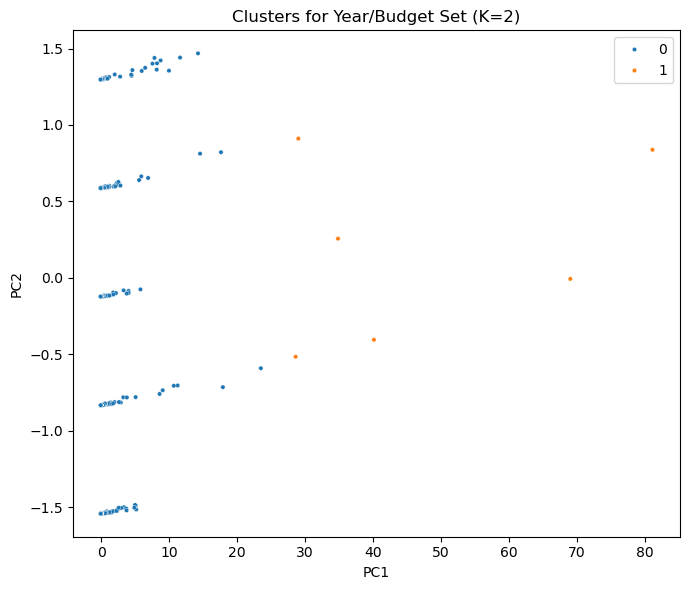

[[2.01717120e+03 5.21990217e+05 2.06089414e+05]
 [2.01666667e+03 7.27652157e+08 1.86333333e+08]]


In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

B = df[["release_year", "revenue", "budget"]].dropna()

B_sample = B.sample(n=10000, random_state=3001)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_sample)

Ks = range(2, 11)
sil_scores_B = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=5, random_state=3001)
    labels = km.fit_predict(B_scaled)
    sil_scores_B.append(silhouette_score(B_scaled, labels))

best_k_B = Ks[int(np.argmax(sil_scores_B))]
print("Best K for Year/Budget Cluster:", best_k_B)

plt.figure(figsize=(7, 4))
plt.plot(Ks, sil_scores_B, marker="o")
plt.title("Silhouette Scores (Year + Revenue + Budget)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

km_B = KMeans(n_clusters=best_k_B, n_init=5, random_state=3001)
labels_B = km_B.fit_predict(B_scaled)

pca_B = PCA(n_components=2)
pc_B = pca_B.fit_transform(B_scaled)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=pc_B[:,0], y=pc_B[:,1], hue=labels_B, palette="tab10", s=10)
plt.title(f"Clusters for Year/Budget Set (K={best_k_B})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

cluster_centers_B = scaler.inverse_transform(km_B.cluster_centers_)
print(cluster_centers_B)




To produce more interpretable K-Means clusters, we separated the analysis into two semantically consistent feature groups rather than clustering on the full feature matrix. First, we clustered using popularity, vote_count, and avg_popularity, which all represent audience engagement and therefore share a similar scale and meaning. After scaling the data and evaluating K from 2 to 10, the best silhouette score occurred at K=2. The PCA visualization shows two clearly separated groups. The cluster centers indicate that Cluster 0 corresponds to the large majority of films with low popularity scores, low vote counts, and relatively modest average popularity, while Cluster 1 contains the small minority of high-popularity, heavily rated, breakout films. This aligns with expectations, since popularity measures are strongly right-skewed, producing a natural separation between blockbusters and the long tail of typical releases.

Second, we applied K-Means to release_year, revenue, and budget, which groups films along a production and financial axis. Again, after scaling and evaluating silhouette scores, the best performing model was K=2. The PCA scatterplot shows one dense group and one sparse group. When transformed back into the original scale, the centers show that Cluster 0 represents the majority of films: mid-budget movies with modest revenues spanning a wide range of release years. Cluster 1, in contrast, contains the exceptionally high-budget and extremely high-revenue movies, which tend to drive the global box office. The silhouette for K=2 is very high, indicating that budget and revenue naturally form a clean split between normal films and a small set of extreme financial outliers. Overall, these subset-specific clusterings reveal meaningful film groupings that were hidden when clustering on all numeric features simultaneously.

## PCA

Explained Variance Ratios: [0.20788392 0.12253386 0.09141204 0.09014427 0.08816844 0.07783555
 0.06402571 0.05448533 0.05192223 0.04442861 0.03619715 0.03528479
 0.01961907 0.01605901 0.        ]
Cumulative: [0.20788392 0.33041779 0.42182982 0.5119741  0.60014254 0.6779781
 0.74200381 0.79648914 0.84841137 0.89283998 0.92903713 0.96432192
 0.98394099 1.         1.        ]


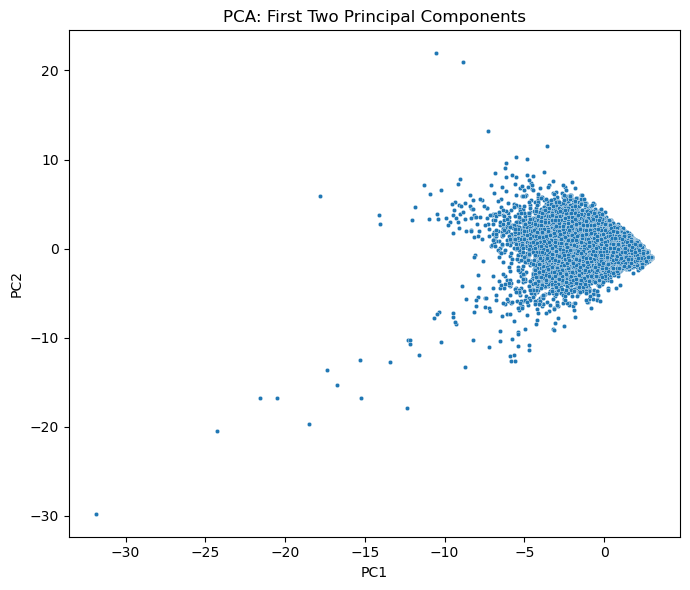

In [246]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)

pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_var)
print("Cumulative:", np.cumsum(explained_var))

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: First Two Principal Components")
plt.tight_layout()
plt.show()


The PCA results show that the first two principal components explain roughly 33 percent of the total variance, and it takes about eight components to exceed 90 percent cumulative variance. This indicates that the data is moderately high dimensional and the structure is spread across many correlated numeric features rather than dominated by one or two strong latent factors. The PC1 vs. PC2 scatterplot shows a dense core of observations with several elongated directions, suggesting heterogeneity driven by variables like popularity, revenue, and vote count. The lack of clearly separated groups reinforces what we saw in K means: the dataset does not have strong natural clusters in the full feature space.

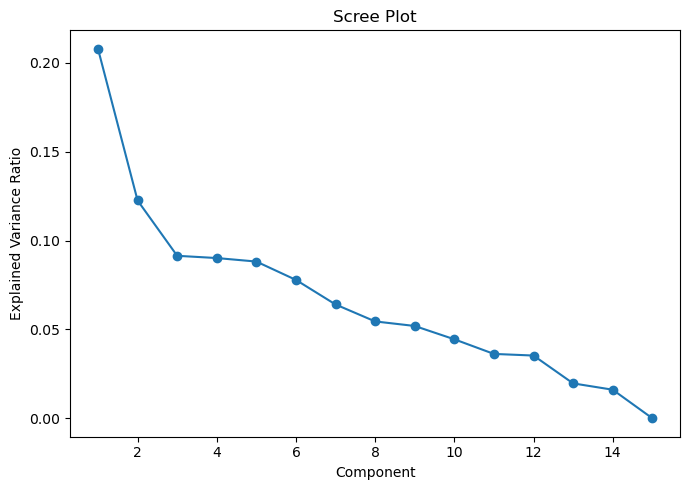

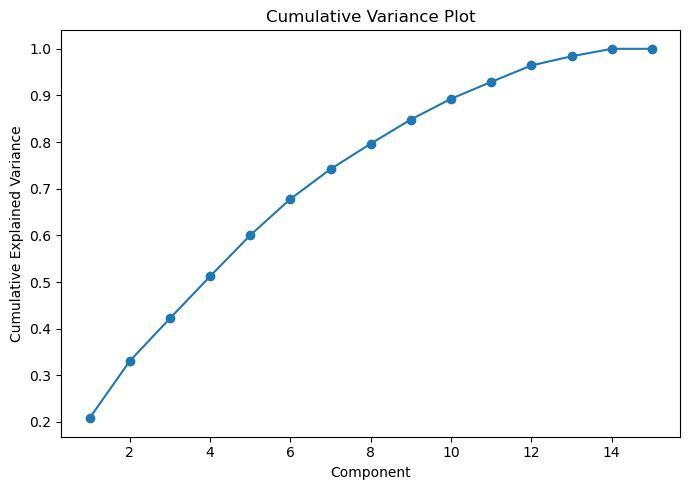

In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)

pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_

plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained) + 1), np.cumsum(explained), marker="o")
plt.xlabel("Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Plot")
plt.tight_layout()
plt.show()


In [248]:
import pandas as pd

loadings = pd.DataFrame(
    pca.components_,
    columns=X3.columns
)

loadings


,const,popularity,runtime,vote_count,gender_split,min_popularity,avg_popularity,median_popularity,production_company_count,language_count,production_country_count,release_year_2016,release_year_2017,release_year_2018,release_year_2019
0,0.0,-0.356657,-0.311870,-0.214770,0.420785,-0.164526,-0.401740,-0.418747,-0.310951,-0.201706,-0.223521,-0.023312,0.001011,0.007248,0.024497
1,0.0,0.114020,0.163384,0.138206,0.163158,-0.362197,-0.330703,-0.386602,0.383384,0.396857,0.465754,-0.020149,-0.020167,0.008543,0.047747
2,-0.0,-0.022756,-0.018696,-0.034674,0.011770,0.037245,0.037712,0.044148,0.000964,0.023497,0.000434,-0.101046,-0.236237,-0.503871,0.820107
3,0.0,0.012097,0.022443,0.036284,-0.000183,-0.026528,-0.023581,-0.026829,-0.013441,-0.020609,0.013784,0.124043,0.721525,-0.655302,-0.172776
4,-0.0,0.025966,0.025528,0.037674,-0.001984,-0.038041,-0.036692,-0.032457,-0.013171,-0.043943,-0.020533,0.855708,-0.416432,-0.246413,-0.156548
5,0.0,0.452008,0.046018,0.649347,-0.021867,-0.324422,-0.057430,-0.136081,-0.163762,-0.281593,-0.354934,-0.082266,-0.018103,0.017470,0.069890
6,0.0,-0.055359,0.573464,-0.467473,-0.317361,-0.528940,-0.001278,-0.019134,-0.096558,-0.068720,-0.231171,-0.028464,-0.003321,0.000209,0.019306
7,0.0,0.057853,0.417468,0.099171,0.029185,0.464507,-0.252999,-0.141531,-0.401600,0.532387,-0.259114,-0.001364,-0.003370,-0.000226,-0.002869
8,-0.0,-0.113318,-0.378791,0.085397,-0.017300,-0.457172,0.333925,0.167865,-0.329605,0.608674,-0.080599,0.030977,0.004736,-0.006496,-0.027370
9,0.0,0.655179,-0.423502,-0.437735,-0.327163,0.069434,-0.238682,-0.132999,-0.061690,0.093804,-0.021990,0.001845,0.005220,-0.011798,0.001574


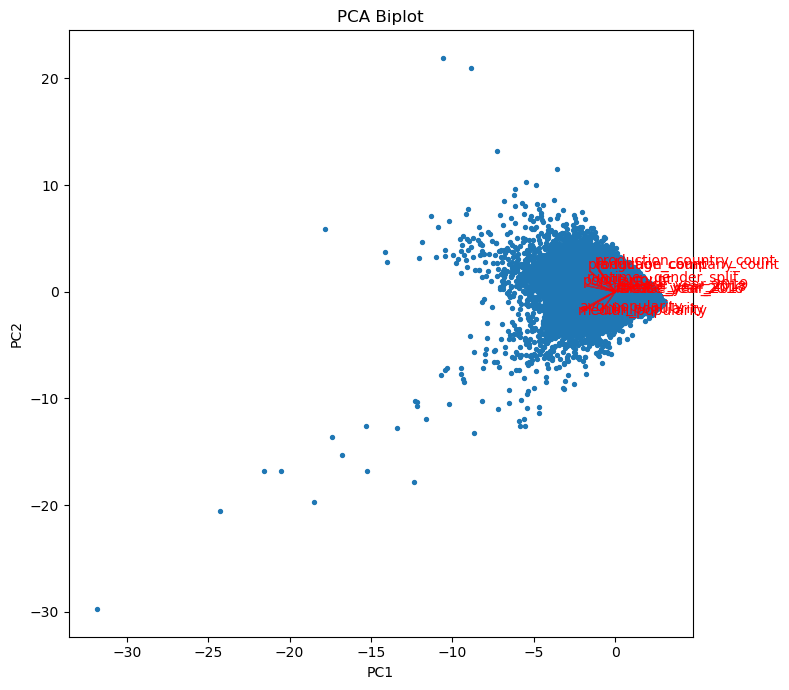

In [249]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(8,7))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")

for i, col in enumerate(X3.columns):
    plt.arrow(0, 0, pca2.components_[0,i] * 5, pca2.components_[1,i] * 5, color="red", alpha=0.7)
    plt.text(pca2.components_[0,i] * 5 * 1.1, pca2.components_[1,i] * 5 * 1.1, col, color="red")

plt.tight_layout()
plt.show()


The scree plot shows that PC1 explains about 21 percent of the total variance, PC2 explains about 12 percent, and PC3 explains around 9 percent. After the first several components, the drop in explained variance becomes gradual, which suggests diminishing returns. The cumulative variance plot confirms this: it takes approximately 6 components to explain around 60 percent of the variance, and about 10 components to reach 90 percent. This indicates that the dataset is moderately high dimensional with no single dominant direction.

The PCA biplot reveals how individual variables drive the separation along the first two principal components. PC1 loads heavily on popularity measures (popularity, vote_count, median_popularity, avg_popularity) and production scale variables (production_company_count, language_count, country_count). Larger absolute loadings mean the variable explains more of the variation captured by that component. In contrast, PC2 is more influenced by runtime and release-year indicators. Both components show that popularity metrics form a consistent directional cluster, while release-year dummies contribute much less to global structure.

Together, these results indicate that the primary structure in the data is driven by how big or widely received the film is (popularity, vote volume, company and country counts), not by the release year or smaller metadata fields. If dimensionality reduction is a goal, retaining the first five to seven components will preserve most of the meaningful signal while reducing noise.